<a href="https://colab.research.google.com/github/akitim/Motorica_Gesture_Classification_Task/blob/main/Motorica_gesture_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !mv /content/X_test.npy /home/
# !mv /content/X.npy /home/
# !mv /content/sample_submission.csv /home/
# !mv /content/y_train.csv /home/

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [65]:
X_submit = np.load('/content/X_test.npy')
X = np.load('/content/X_train.npy')
# sample_submission = pd.read_csv('/home/sample_submission.csv')
# y = pd.read_csv('/home/y_train.csv')
    
sample_submission = \
    pd.read_csv('https://raw.githubusercontent.com/akitim/'+
        'Motorica_Gesture_Classification_Task/main/data/sample_submission.csv')
y = \
    pd.read_csv('https://raw.githubusercontent.com/akitim/'+
        'Motorica_Gesture_Classification_Task/main/data/y_train.csv')

In [66]:
# нормализуем X и X_submit на 4096
print(f"до: {X[0, 0, 0:10]} ")
X /= 4096
X_submit /= 4096

print(f'после: {X[0, 0, 0:10]}')

до: [1331. 1333. 1331. 1332. 1334. 1334. 1333. 1334. 1335. 1334.] 
после: [0.32495117 0.32543945 0.32495117 0.32519531 0.32568359 0.32568359
 0.32543945 0.32568359 0.32592773 0.32568359]


# Характеристика датасета

In [48]:
X.shape, y.shape, X_submit.shape
# X_submit

((165, 40, 60), (165, 2), (166, 40, 60))

- "0" - разгиб жеста "grab";
- "1" - разгиб жеста "ok";
- "2" - разгиб большого пальца;
- "3" - разгиб указательного пальца;
- "4" - разгиб жеста "пистолет";
- "5" - разгиб среднего пальца;
- "6" - разгиб безымянного пальца;
- "7" - разгиб мизинца;
- "8" - сгиб мизинца;
- "9" - сгиб безымянного пальца;
- "10" - сгиб среднего пальца;
- "11" - сгиб жеста "пистолет";
- "12" - сгиб указательного пальца;
- "13" - сгиб большого пальца;
- "14" - сгиб жеста "ok";
- "15" - сгиб жеста "grab";

## Классы (y)

In [49]:
y.sample(5)

Id  Class
1      1      8
13    13     12
69    69     11
159  159      0
25    25      7

Количество объектов каждого класса:

In [7]:
y['Class'].value_counts().sort_index()

0     11
1     10
2     10
3     10
4     10
5     11
6     10
7     11
8     10
9     10
10    10
11    10
12    11
13    10
14    10
15    11
Name: Class, dtype: int64

In [67]:
print(f'X_submit shape: {X_submit.shape}\n')
sample_submission.sample(2)

X_submit shape: (166, 40, 60)



Id  Class
73   238      2
145  310     11

In [51]:
def del_emty_axes(axs):
    # удаляем пустые графики
    for axes in axs.flatten():
        if not(axes.has_data()):
            fig.delaxes(axes)
    return None

# def SG_smooth(data=None, window=10, order=3):
#     return np.asarray([savgol_filter(x=channel, window_length=window, polyorder=order) \
#                       for channel in [X for X in X]])

##Удаляем каналы без сигнала

In [68]:
def remove_channels(data=None, n_channels=40, channels_to_remove=[]):
    
    channels_to_remove_mask = np.ones(n_channels, dtype=bool)
    channels_to_remove_mask[channels_to_remove] = False
    
    return data[:, channels_to_remove_mask, :].copy()

num_of_channels = X.shape[1] #40
channels_to_remove = [1, 7, 11, 18, 28, 31, 32, 37, 39]

X_proc = remove_channels(data=X,
                               n_channels=num_of_channels,
                               channels_to_remove=channels_to_remove)
X_submit_proc = remove_channels(data=X_submit,
                               n_channels=num_of_channels,
                               channels_to_remove=channels_to_remove)
print(X_submit.shape, X_submit_proc.shape)

# X_proc = savgol_filter(X_proc, 7, 2)
# X_submit_proc = savgol_filter(X_submit_proc, 7, 3)

print(X_proc.shape, X_submit_proc.shape)

(166, 40, 60) (166, 31, 60)
(165, 31, 60) (166, 31, 60)


##Формируем признаки

In [69]:
X_ = np.mean(X_proc[:, :, 0:30], axis=2)\
    - np.mean(X_proc[:, :, 50:60], axis=2)

X_submit_ = np.mean(X_submit_proc[:, :, 0:15], axis=2)\
    - np.mean(X_submit_proc[:, :, 45:60], axis=2)

#стандартизируем
std_scaler = StandardScaler()
X_ = std_scaler.fit_transform(X_)
X_submit_ = std_scaler.transform(X_submit_)

y_true = y.Class.values

## Строим модель

In [70]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(
    X_, y_true, test_size=0.2,
    random_state=RANDOM_SEED
)

Cs = np.logspace(-2, 3, 4)
l1_ratios = [0, 0.25, 0.5, 0.75, 1]

params = {'Cs': Cs,
          'cv': 2,
          'penalty': 'elasticnet', #['l1', 'l2']
          'scoring': 'f1_macro',
          'solver': 'saga',
          'tol': 0.0001,
          'max_iter': 1000,
          'n_jobs': -1,
          'multi_class': 'multinomial',
          'random_state': RANDOM_SEED,
          'l1_ratios': l1_ratios
}

logreg = LogisticRegressionCV(**params)
logreg.fit(X=X_train, y=y_train)

y_pred = logreg.predict(X_test)

print (f"Средняя F-мера: {f1_score(y_test, y_pred, average='macro')}")

Средняя F-мера: 0.8666666666666667


In [71]:
X_submit_.shape

(166, 31)

## Submit

In [77]:
y_submit = logreg.predict(X_submit_)

submission = pd.DataFrame({'Id': sample_submission.Id.values, 'Class': y_submit})

# submission_str = 'Id,Class'
# for q in range(166):
#     submission_str += '\n' + str(q) + ',' + str(y_submit[q])  

# with open ('submission.csv', 'w', encoding="utf-8") as submission_file:
#     submission_file.write(submission_str)

submission_file.close()

# print(submission_str)
    # print (submission_str)
submission.to_csv('/content/submission.csv', index=False)

## Развертка жестов по каналам

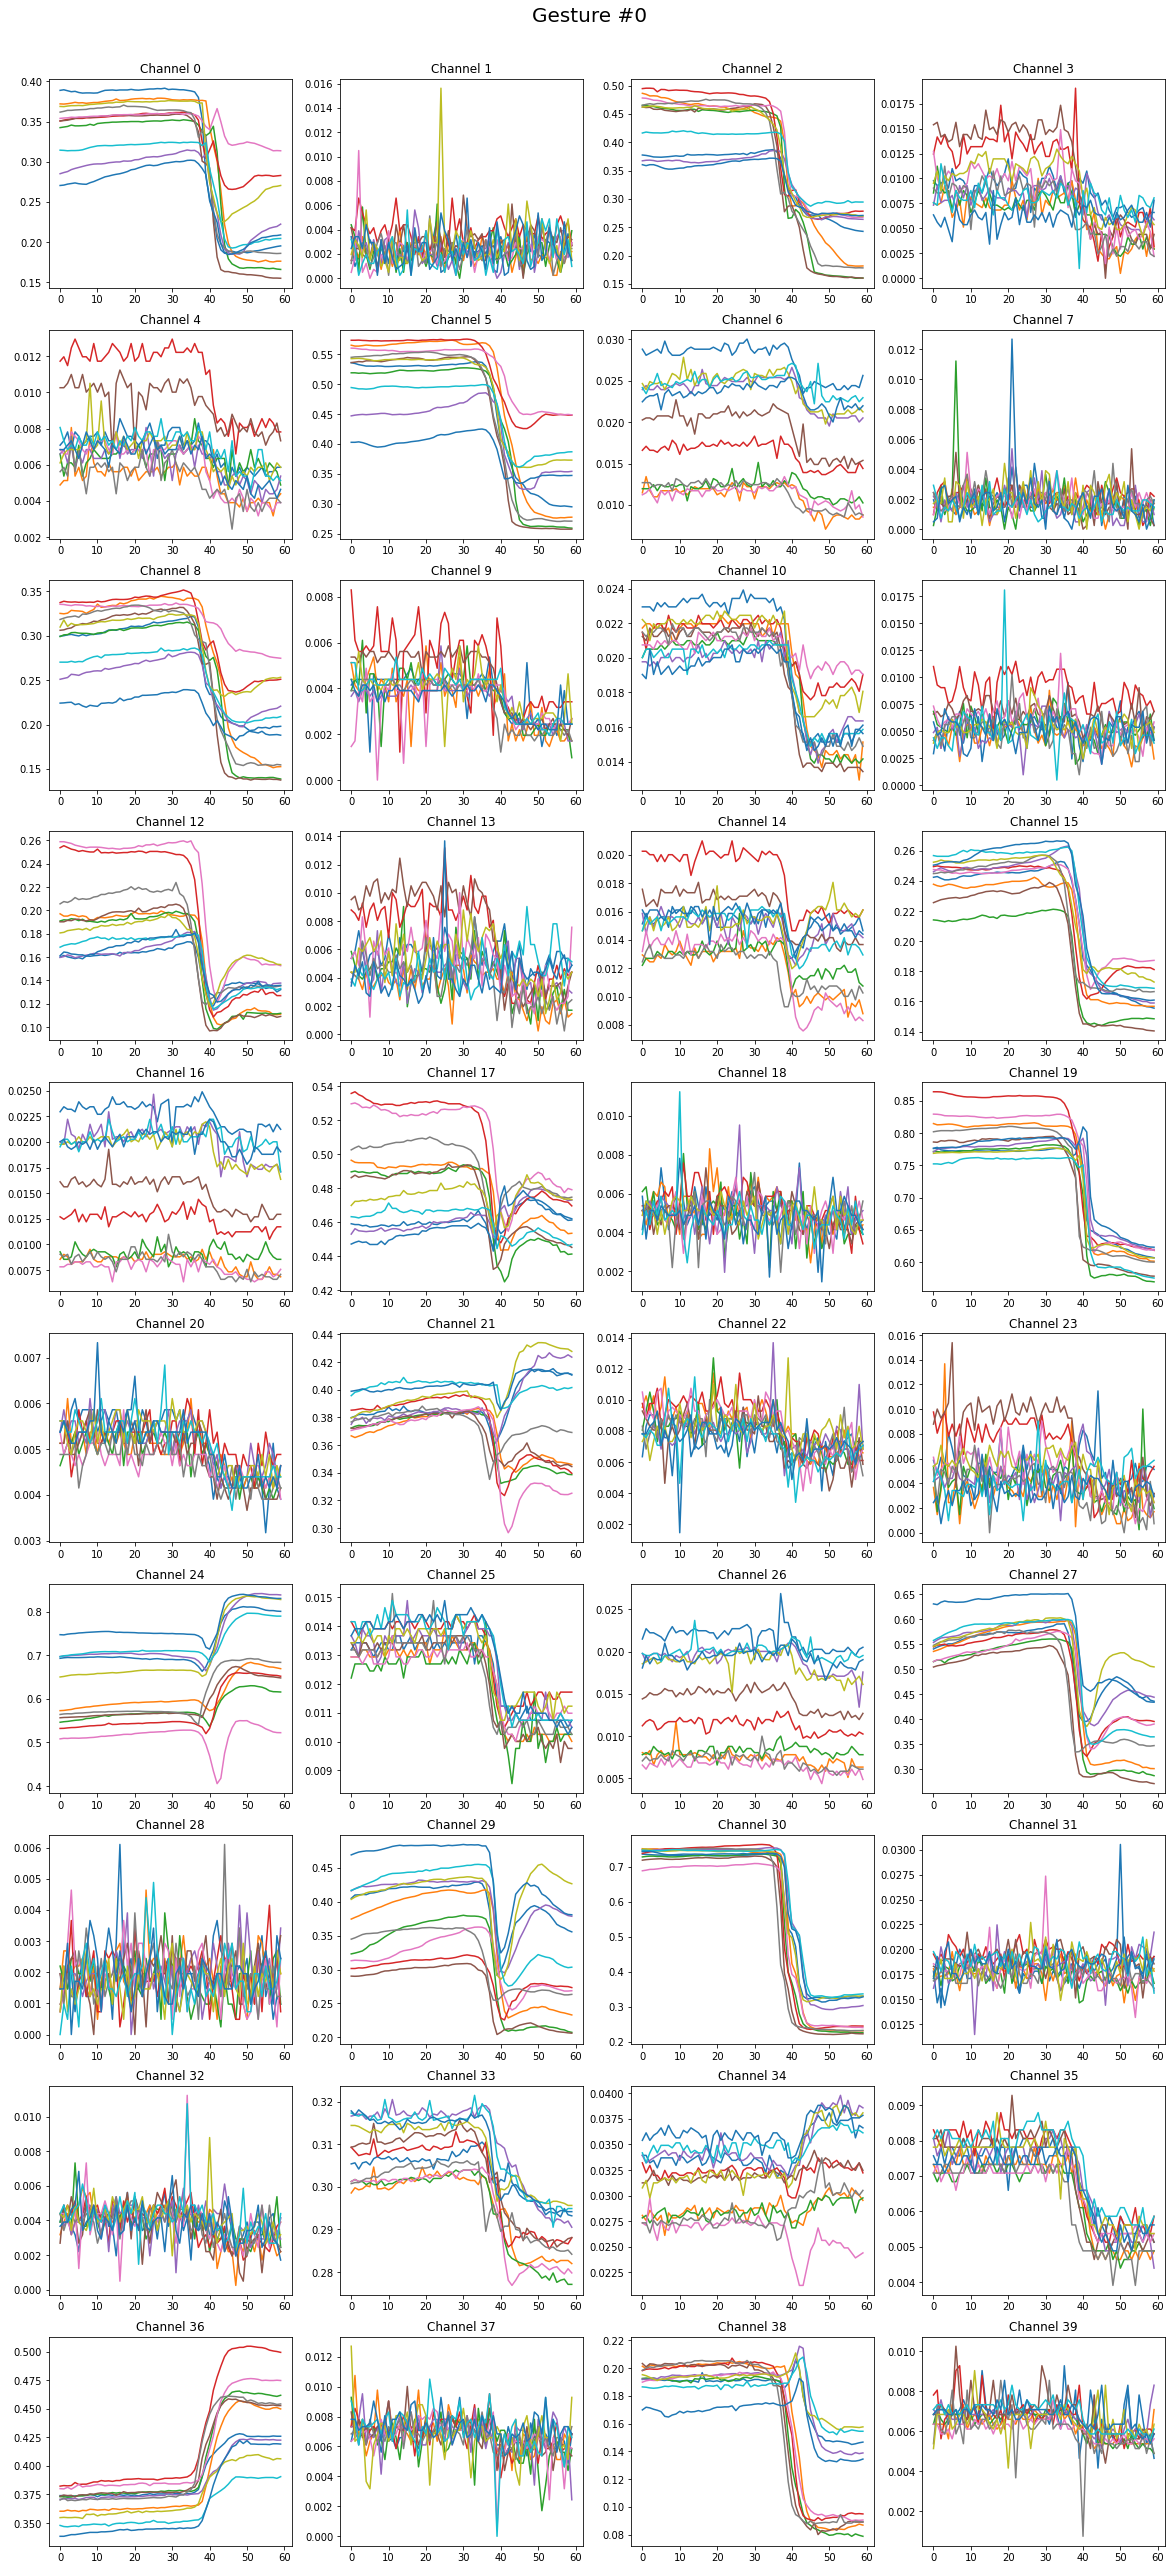

In [14]:
# "0" - разгиб жеста "grab";
# "1" - разгиб жеста "ok";
# "2" - разгиб большого пальца;
# "3" - разгиб указательного пальца;
# "4" - разгиб жеста "пистолет";
# "5" - разгиб среднего пальца;
# "6" - разгиб безымянного пальца;
# "7" - разгиб мизинца;
# "8" - сгиб мизинца;
# "9" - сгиб безымянного пальца;
# "10" - сгиб среднего пальца;
# "11" - сгиб жеста "пистолет";
# "12" - сгиб указательного пальца;
# "13" - сгиб большого пальца;
# "14" - сгиб жеста "ok";
# "15" - сгиб жеста "grab";

# X_smoothed = X
X_smoothed = X #savgol_filter(X, 7, 3)
# cls_ls = list(range(16))
cls_ls = [0]

for k in range(1):
    # индексы одного класса в X
    cls = cls_ls[k] # метка жеста 
    cls_indices = np.asarray(y[y['Class'] == cls].index)

    num_of_channels = X_smoothed.shape[1]

    fig_n_cols = 4
    fig, axs = plt.subplots(num_of_channels // fig_n_cols + 1, fig_n_cols, 
                        figsize=(20, 5 * num_of_channels // fig_n_cols))
    fig.suptitle(t=f'Gesture #{cls}', y=0.9, fontsize=20);

    # строим графики всех наблюдений одного класса в X
    for i in range(num_of_channels):
        ax_curr = axs[i // fig_n_cols, i % fig_n_cols]
        ax_curr.set_title(f'Channel {i}')

        for j in range(len(cls_indices)):
            # X_sm = savgol_filter(X[cls_indices[j], i, :], 5, 3)
            d = np.diff(X_smoothed[cls_indices[j], i, :], n=0)
            ax_curr.plot(d, label=cls);
            # ax_curr.text(j*3, d[j*3], f'{j}');

del_emty_axes(axs)

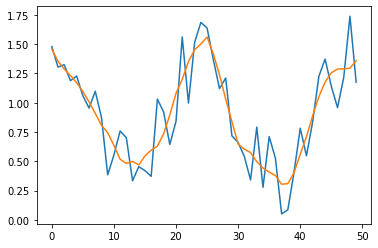

In [16]:
k = 1.3
a = np.array(
    [
        [np.sin(np.linspace(0, 2*np.pi)+np.random.rand(50)/k), 
         np.cos(np.linspace(0, 2*np.pi))+np.random.rand(50)/k],
        [np.sin(np.linspace(0, 2*np.pi))**2+np.random.rand(50)/k, 
         np.cos(np.linspace(0, 2*np.pi))**2+np.random.rand(50)/k],
        [np.sin(np.linspace(0, 2*np.pi))**3+np.random.rand(50)/k, 
         np.cos(np.linspace(0, 2*np.pi))**3+np.random.rand(50)/k]
    ]
)

plt.plot(a[1, 1, :]);
# L = np.asarray([savgol_filter(a, 3, 2) for x in a])
# L.reshape(2, 3)
plt.plot(savgol_filter(a, 17, 5)[1, 1, :]);


## Развертка каналов по жестам

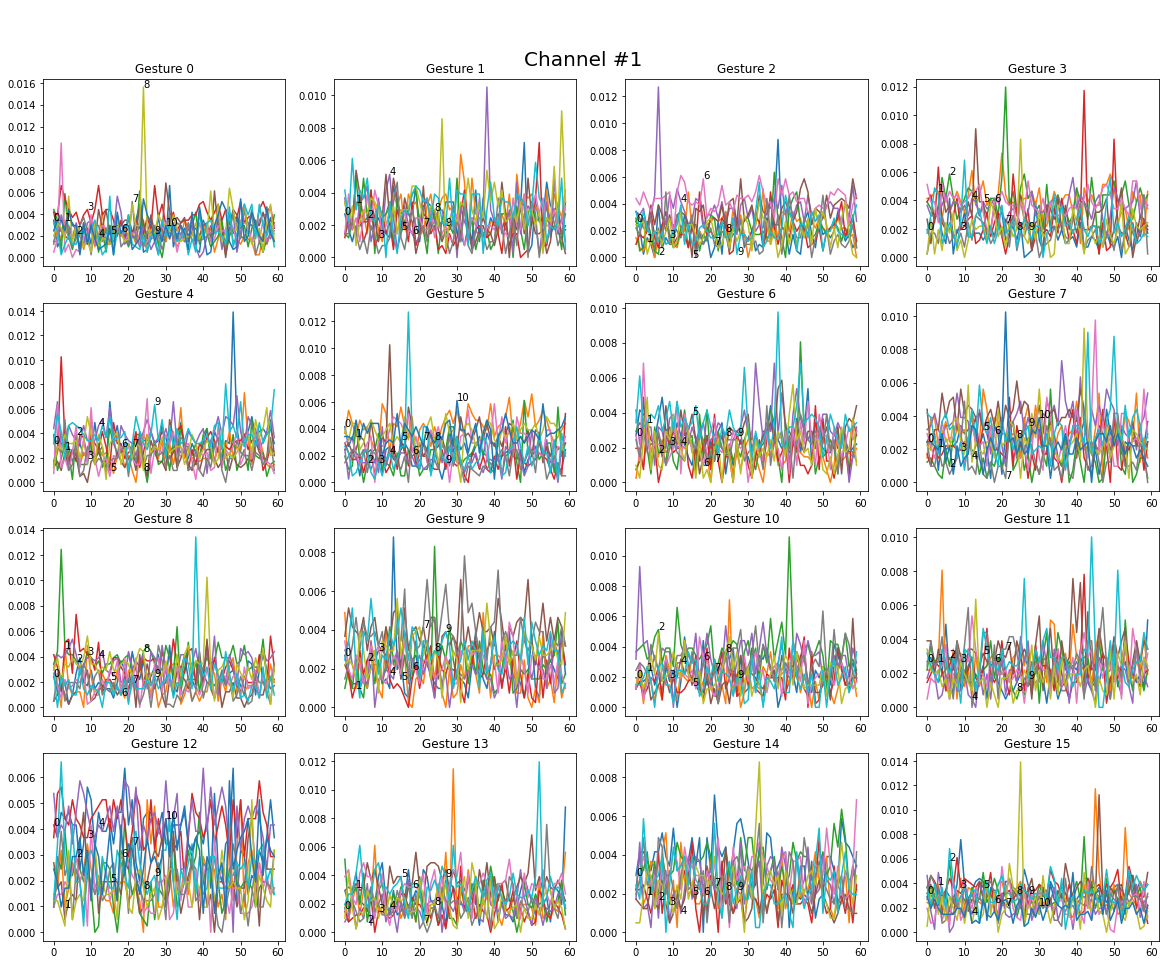

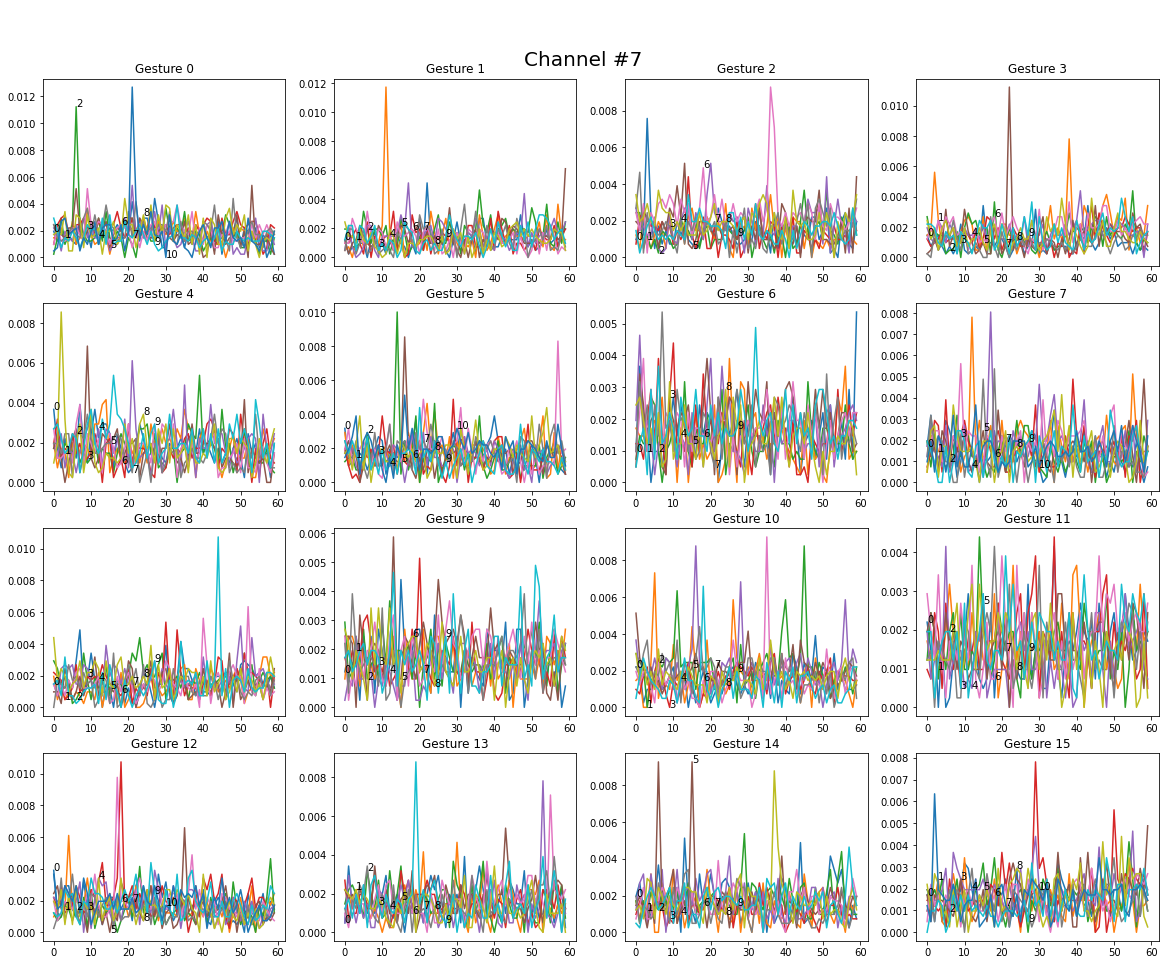

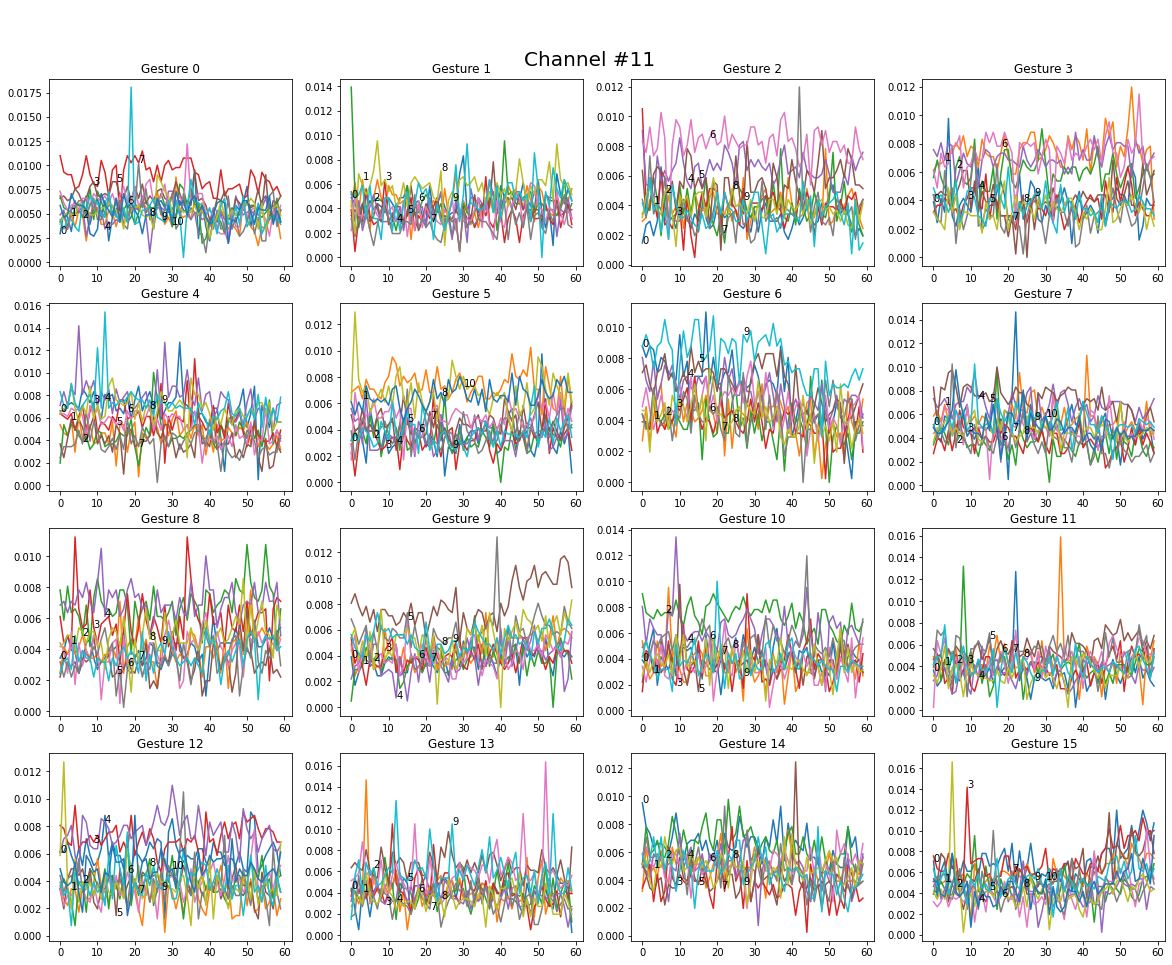

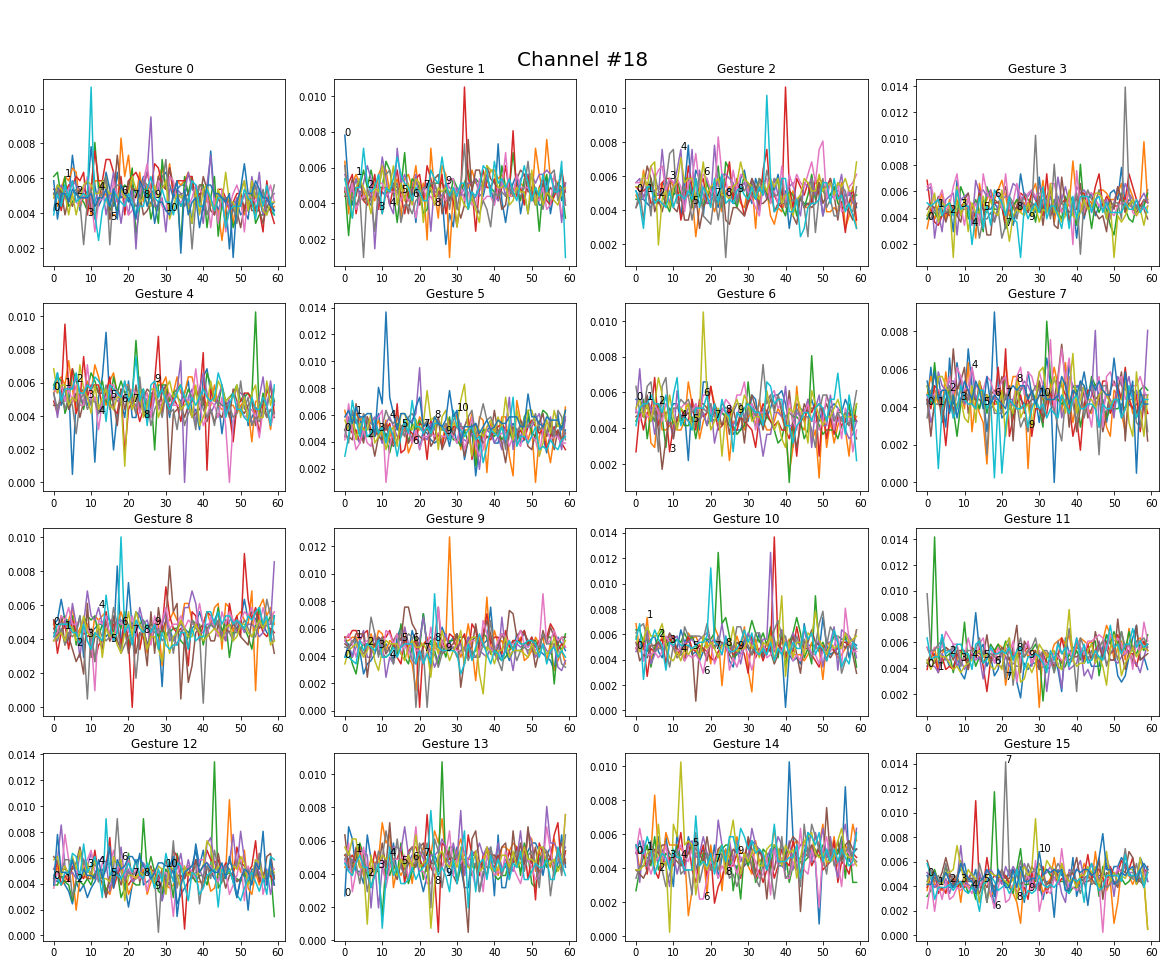

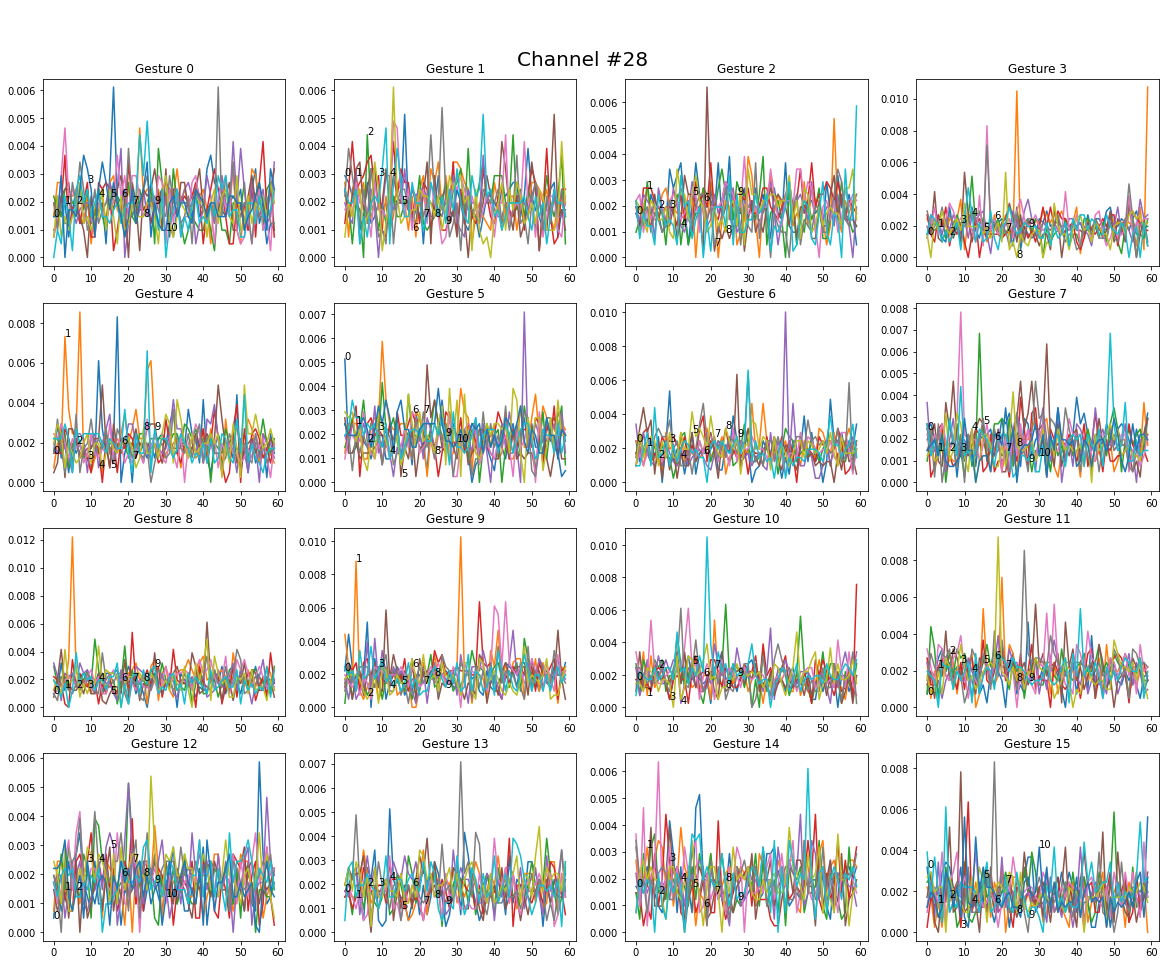

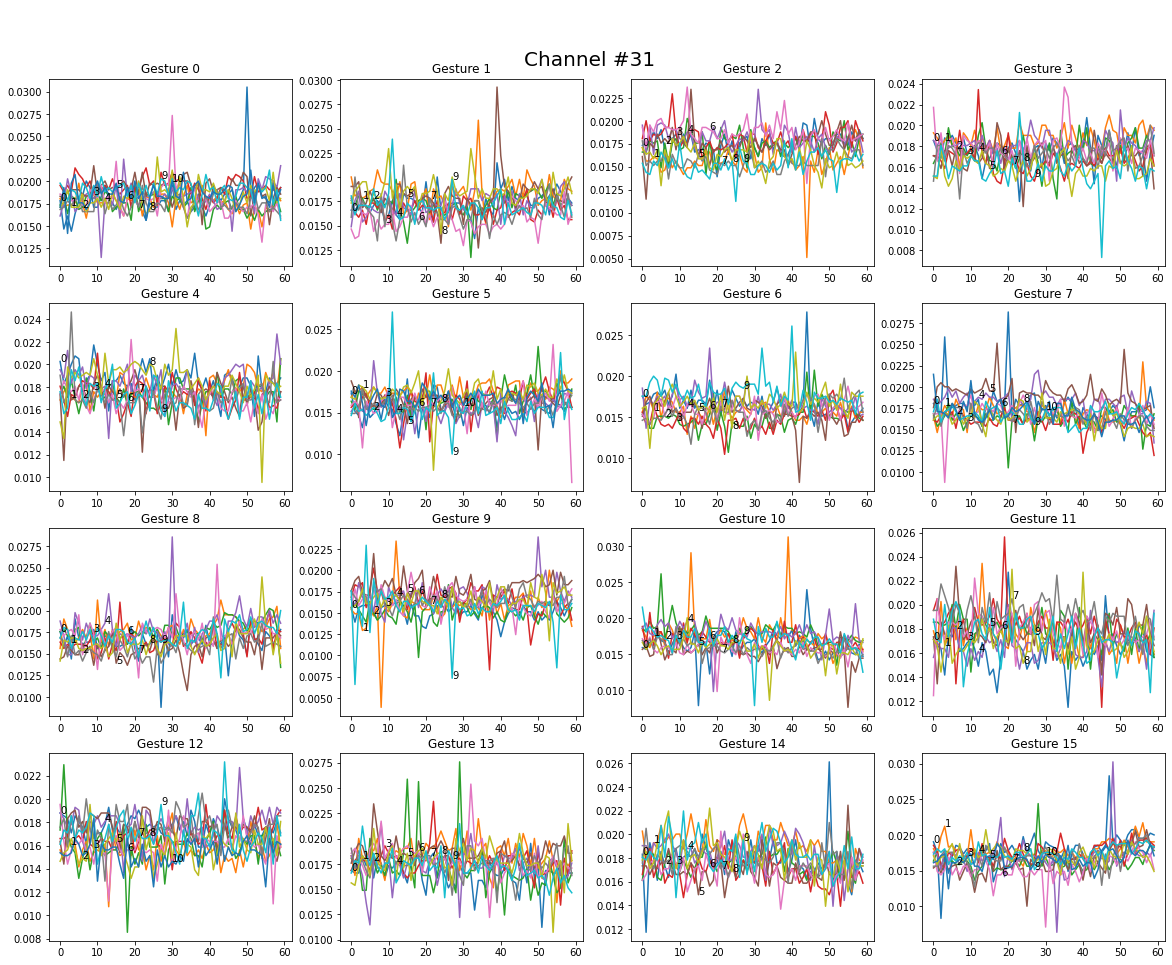

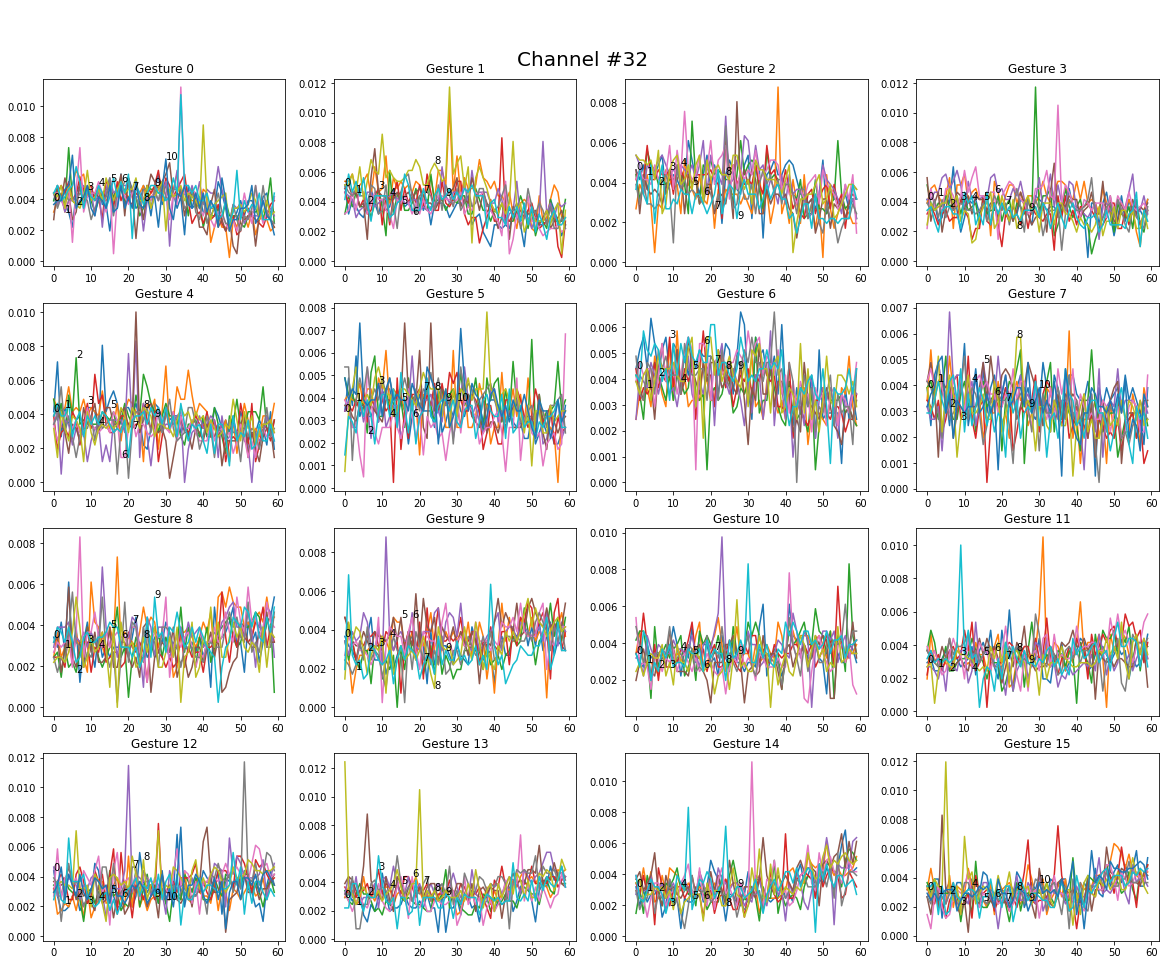

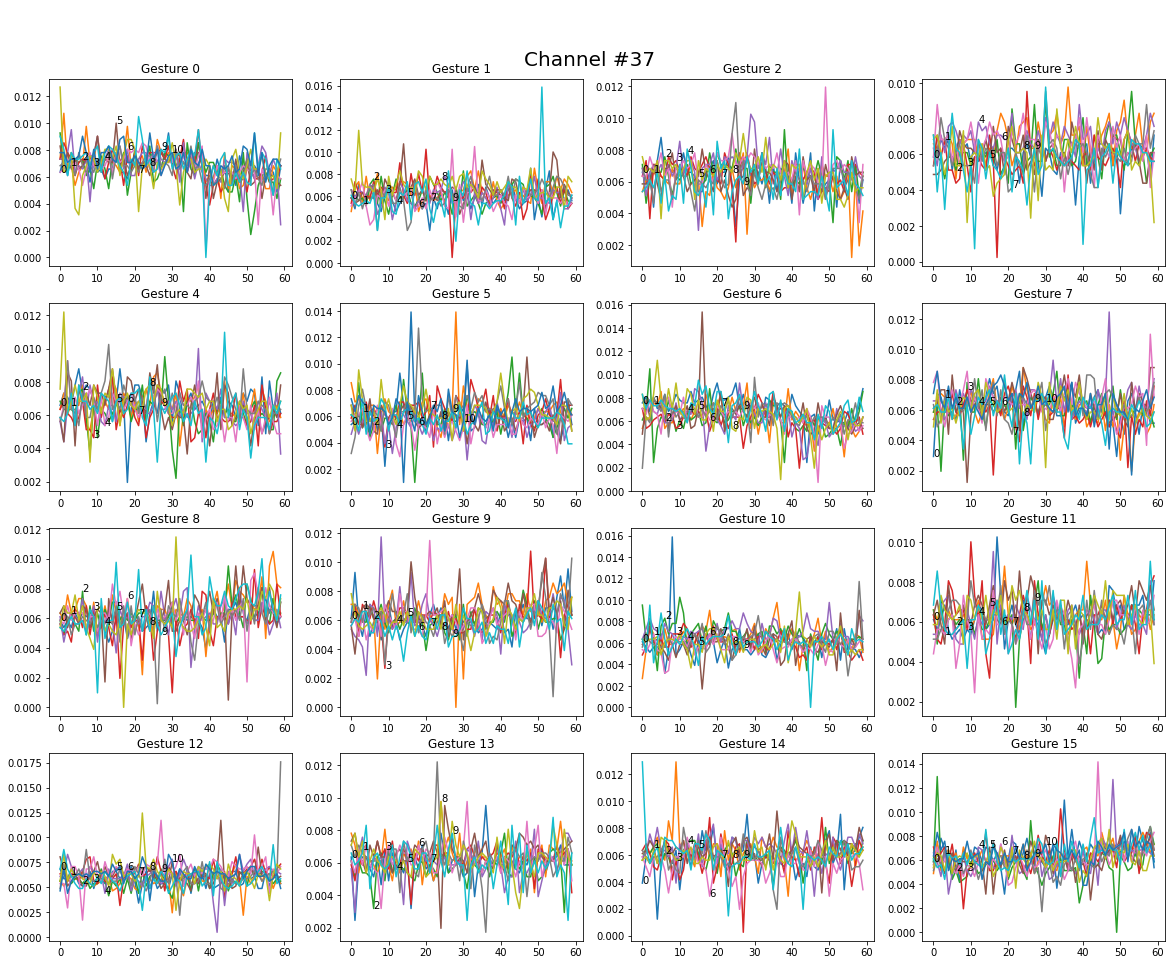

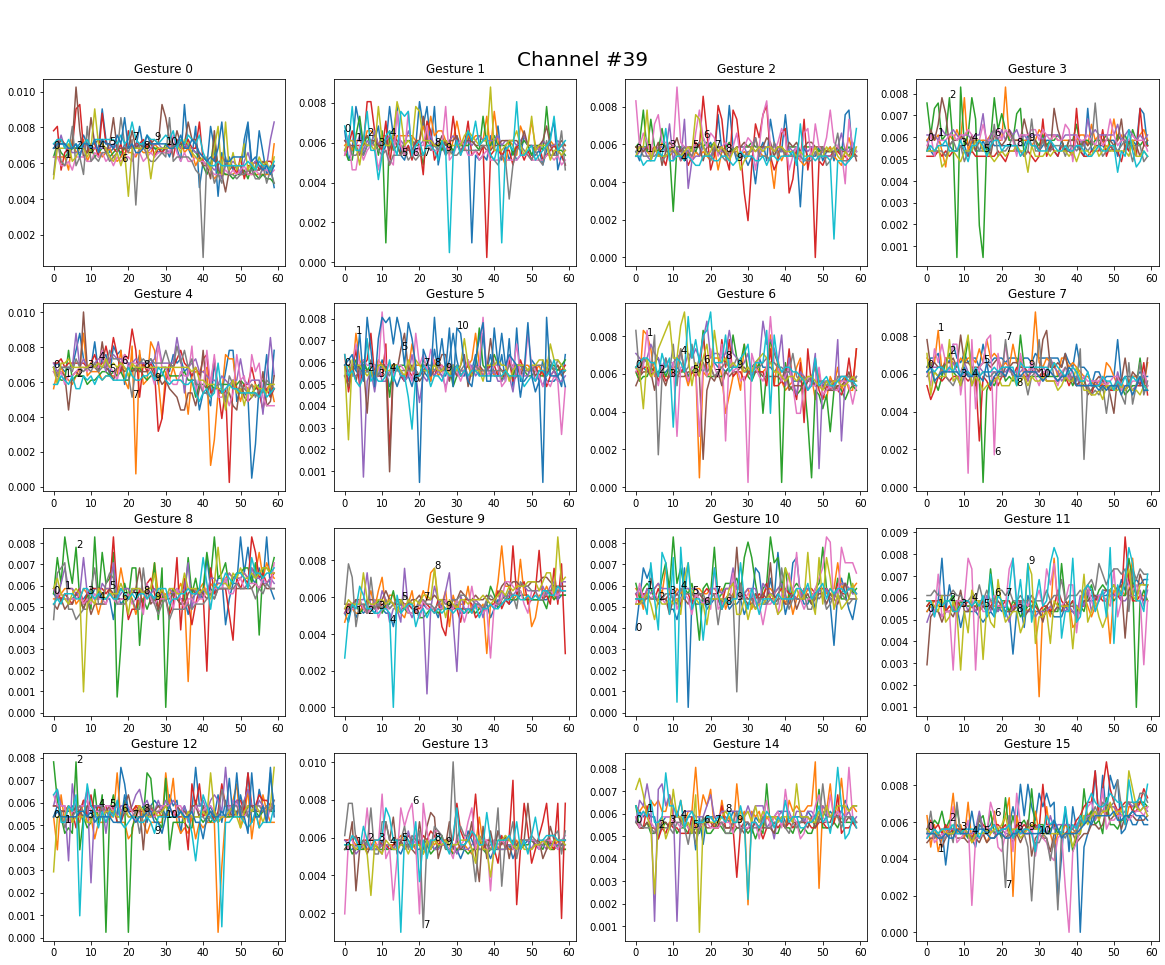

In [17]:
channel_ls = [1, 7, 11, 18, 28, 31, 32, 37, 39]

for k in range(len(channel_ls)):
    # индексы одного класса в X
    channel = channel_ls[k] # метка жеста 
    
    num_of_channels = X.shape[1]

    n_of_classes = 16

    fig_n_cols = 4
    fig, axs = plt.subplots(n_of_classes // fig_n_cols + 1, fig_n_cols, 
                        figsize=(20, 5 * n_of_classes // fig_n_cols))
    fig.suptitle(t=f'\n\nChannel #{channel}', y=0.93, fontsize=20);

    # строим графики всех наблюдений одного класса в X
    for i in range(n_of_classes):
        ax_curr = axs[i // fig_n_cols, i % fig_n_cols]
        ax_curr.set_title(f'Gesture {i}')
        cls_indices = np.asarray(y[y['Class'] == i].index)
        
        # XG = np.zeros((len(cls_indices), 60)) #on to heatmap

        for j in range(len(cls_indices)):
            ax_curr.plot(X[cls_indices[j], channel, :], label=f'{j}'); #off to heatmap
            # XG[j, :] = X[cls_indices[j], channel, :] #on to heatmap
            # sns.heatmap(data=XG, ax=ax_curr, cbar=False, cmap='coolwarm'); #on to heatmap
            ax_curr.text(j*3, X[cls_indices[j], channel, j*3], f'{j}'); #off to heatmap
        
    del_emty_axes(axs)

In [18]:
X[0, 0, :]

array([0.32495117, 0.32543945, 0.32495117, 0.32519531, 0.32568359,
       0.32568359, 0.32543945, 0.32568359, 0.32592773, 0.32568359,
       0.32495117, 0.32470703, 0.32348633, 0.32324219, 0.32250977,
       0.32226562, 0.32226562, 0.32226562, 0.32250977, 0.32250977,
       0.32177734, 0.32177734, 0.32177734, 0.32128906, 0.32080078,
       0.32055664, 0.32055664, 0.32006836, 0.31958008, 0.3190918 ,
       0.31835938, 0.31762695, 0.31689453, 0.31665039, 0.31689453,
       0.31665039, 0.31567383, 0.31201172, 0.30004883, 0.28100586,
       0.27392578, 0.24755859, 0.22509766, 0.21728516, 0.21508789,
       0.21386719, 0.21240234, 0.21069336, 0.20825195, 0.20556641,
       0.20385742, 0.20288086, 0.20214844, 0.2019043 , 0.20239258,
       0.203125  , 0.20336914, 0.20458984, 0.20556641, 0.20703125])

In [19]:
# X[2, 0].shape
X[164, 0, :]

array([0.19873047, 0.19848633, 0.19897461, 0.19995117, 0.20019531,
       0.20092773, 0.20166016, 0.20336914, 0.20361328, 0.20239258,
       0.20288086, 0.20239258, 0.20361328, 0.20483398, 0.20532227,
       0.20483398, 0.20581055, 0.20727539, 0.20751953, 0.20776367,
       0.20776367, 0.20825195, 0.20947266, 0.21020508, 0.2109375 ,
       0.21118164, 0.21166992, 0.21264648, 0.21313477, 0.21362305,
       0.21484375, 0.21557617, 0.21606445, 0.21655273, 0.21679688,
       0.21826172, 0.21875   , 0.21923828, 0.2175293 , 0.21020508,
       0.19775391, 0.18945312, 0.18725586, 0.19042969, 0.19165039,
       0.19213867, 0.19287109, 0.19140625, 0.19091797, 0.19091797,
       0.19018555, 0.18896484, 0.18847656, 0.1875    , 0.18652344,
       0.18554688, 0.18505859, 0.18432617, 0.18383789, 0.18334961])